Source tutorial: [Anomaly Detection in Python with Gaussian Mixture Models](https://towardsdatascience.com/understanding-anomaly-detection-in-python-using-gaussian-mixture-model-e26e5d06094b)

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Load dataset

In [2]:
dataset = sio.loadmat('./anomalyData.mat')
X = dataset['X']
Xval = dataset['Xval']
yval = dataset['yval']

## Or generate a blob dataset

In [3]:
# OR GENERATE A BLOB DATASET
#from sklearn.datasets.samples_generator import make_blobs
#X, y_true = makBe_blobs(n_samples=500, centers=1, cluster_std=0.60, random_state=5)
#X_append, y_true_append = make_blobs(n_samples=20,centers=1, cluster_std=5,random_state=5)
#X = np.vstack([X,X_append])
#y_true = np.hstack([y_true, [1 for _ in y_true_append]])
#X = X[:, ::-1] 

# Definition of functions

In [4]:
def estimateGaussian(X):
    m = X.shape[0]
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = (sum_/m)
    # compute variance of X
    var = np.var(X,axis=0)
    #print(mu, var)
    return mu,var

In [5]:
def multivariateGaussian(X, mu, sigma2):
    k = len(mu)
    sigma2 = np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p



# Compute Multivariate Gaussian for whole dataset

In [6]:
mu,sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)

## Scatter plot of the dataset

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

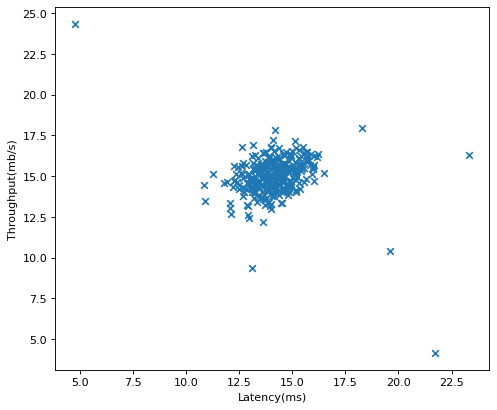

In [8]:
figure(figsize=(7, 6), dpi=80)
plt.scatter(X[:,0],X[:,1],marker="x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

## Visualize with probabilities

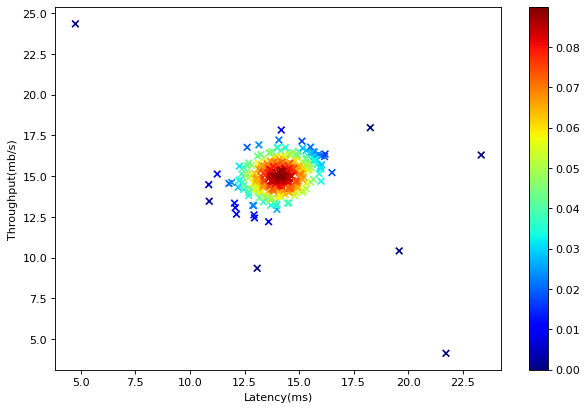

In [9]:
figure(figsize=(9, 6), dpi=80)
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='jet')
plt.colorbar()
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

# Compute outliers
## for a threshold probability epsilon = 0.02

[  8  19  69  71 109 114 142 145 147 170 199 222 226 241 249 299 300 301
 303 304 305 306]


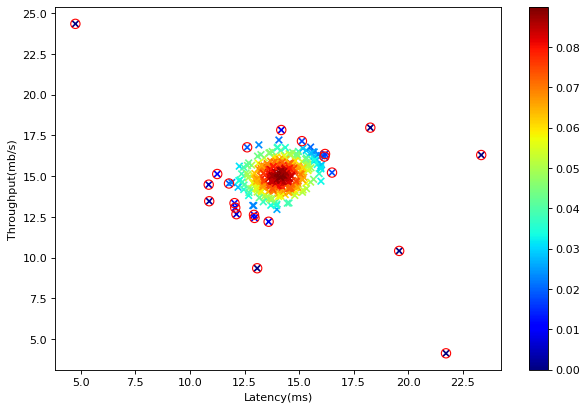

In [10]:
epsilon = 0.02

figure(figsize=(9, 6), dpi=80)
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='jet')
plt.colorbar()
# Circling of anomalies
outliers = np.nonzero(p < epsilon)[0]
print(outliers)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

# Repeat for several clusters
## using `make_blobs` function

In [11]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

X, y_true = make_blobs(n_samples=400, centers=5, cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5, cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.35, random_state=1, shuffle=True)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


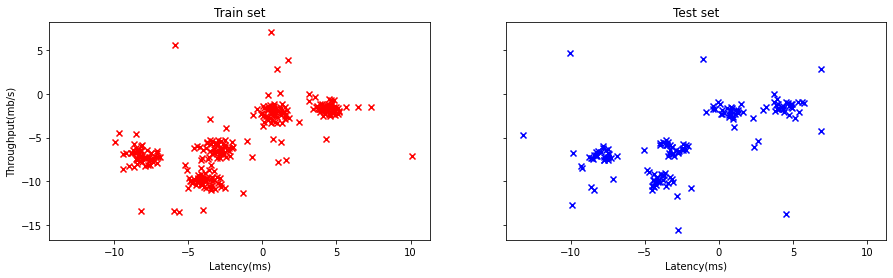

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharex=True, sharey=True)

ax[0].set(title='Train set', xlabel='Latency(ms)', ylabel='Throughput(mb/s)')
ax[0].scatter(X_train[:,0],X_train[:,1],marker="x", color='red')

ax[1].set(title='Test set', xlabel='Latency(ms)')
ax[1].scatter(X_test[:,0],X_test[:,1],marker="x", color='blue')
plt.show()

## Compute Multivariate Gaussian on the TRAIN set

In [13]:
# Estimate Gaussian probability density function
mu_, sigma2_ = estimateGaussian(X_train)
# And compute probabilities for each data point
p_train = multivariateGaussian(X_train, mu_, sigma2_)
print("Select epsilon closer to the lower bound of the probability interval (",
      "{:.2e}".format(min(p_train)), ",","{:.2e}".format(max(p_train)),")" )

Select epsilon closer to the lower bound of the probability interval ( 1.62e-05 , 1.04e-02 )


### Select threshold probability

In [14]:
# To fit current probability levels of the model
## Reducing it will avoid many false positives
### So take at least one order or magnitude below the bivariate epsilon, i.e. 0.02/10= 0.002
### And also check the statement above
epsilon = 0.002

# Then extract the outliers in the train set
outliers_train = np.nonzero(p_train < epsilon)[0]
print("There is a fraction of", "{:.2f}".format( outliers_train.shape[0]/p_train.shape[0] ),
      "outliers in the TRAIN set")

There is a fraction of 0.12 outliers in the TRAIN set


## Compute Multivariate Gaussian on the TEST set

In [15]:
p_test = multivariateGaussian(X_test, mu_, sigma2_)
outliers_test = np.nonzero(p_test < epsilon)[0]
print("There is a fraction of", "{:.2f}".format( outliers_test.shape[0]/p_test.shape[0] ), "outliers in the TEST set")

There is a fraction of 0.17 outliers in the TEST set


## Visually check the performance in the test set

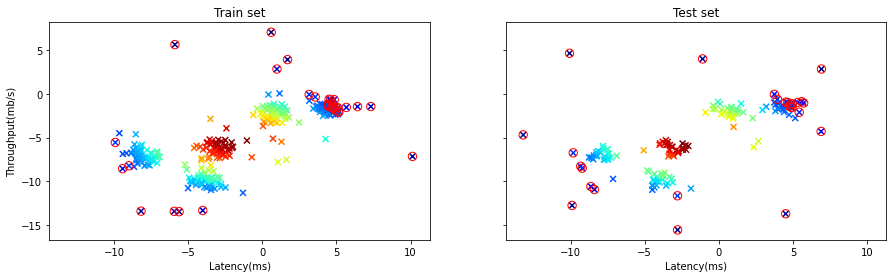

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharex=True, sharey=True)

ax[0].set(title='Train set', xlabel='Latency(ms)', ylabel='Throughput(mb/s)')
ax[0].scatter(X_train[:,0],             X_train[:,1],             marker="x",c=p_train,cmap='jet')
ax[0].scatter(X_train[outliers_train,0],X_train[outliers_train,1],marker="o",facecolor="none",edgecolor="r",s=70)

ax[1].set(title='Test set', xlabel='Latency(ms)')
ax[1].scatter(X_test[:,0],            X_test[:,1],            marker="x",c=p_test,cmap='jet')
ax[1].scatter(X_test[outliers_test,0],X_test[outliers_test,1],marker="o",facecolor="none",edgecolor="r",s=70)

plt.show()

We can see that our model performs quite well.
Now let-s try a more accurate approach using the Mixture of Gaussians.

# Mixture of Gaussians algorythm

In [17]:
n_components = 4
# n_components = 5 doesn't detect the fith blob, so let´'s keep the model simpler

In [18]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = n_components, covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(n_components=4, random_state=0)

## Probability of each point being part of any of the five clusters
All other points far from every target cluster are encircled

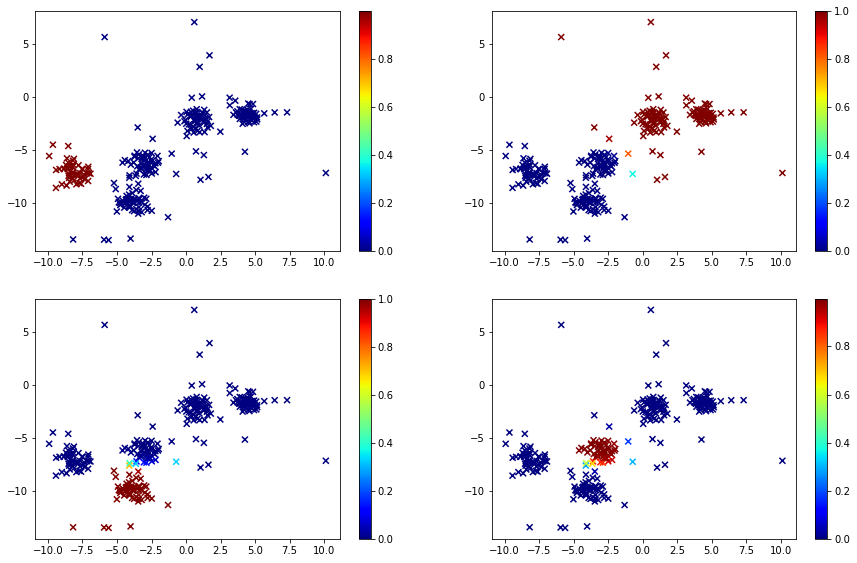

In [19]:
epsilon = 0.2

plt.figure(figsize=(15,15))
for i in range(n_components):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='jet',marker='x')
    plt.colorbar()
    # Circling of anomalies
    outliers = np.nonzero(gm.predict_proba(X_train)[:,i] < epsilon)[0]
    #plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor="none",edgecolor="g",s=70)

In [ ]:
epsilon = 0.2

plt.figure(figsize=(15,15))
for i in range(n_components):
    plt.subplot(3,2,i+1)
    plt.scatter(X_test[:,0],X_test[:,1],c=gm.predict_proba(X_test)[:,i],cmap='jet',marker='x')
    plt.colorbar()
    # Circling of anomalies
    outliers = np.nonzero(gm.predict_proba(X_test)[:,i] < epsilon)[0]
    #plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)